In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2

from camera_calibration import read_calibration, undistort_image
#from color_and_gradient import hls_select, pipeline

import sys
sys.path.append('../')
from utils.plot_utils import plt_imlist

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [175]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,1]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    ret = np.zeros_like(s_channel)
    ret[(s_binary == 1) | (sxbinary == 1)] = 1
    
    h_filtered = cv2.inRange(hls, (0, 0, 0), (40, 255, 255))    
    ret2 = np.zeros_like(s_channel)    
    ret2 = s_binary | ((h_filtered//255) & sxbinary)
    
    
    return ret, ret2

In [176]:
images = glob.glob("test_images/**.jpg")

m = read_calibration("intrinsics.p")
for image in images[:3]:
    img = mpimg.imread(image)
    img_rect = undistort_image(img, m)
    edge,_ = pipeline(img_rect, s_thresh=(170, 255), sx_thresh=(20, 100))
    #plt_imlist([img_rect, hls_binary, edge])    

<Figure size 2160x1080 with 0 Axes>

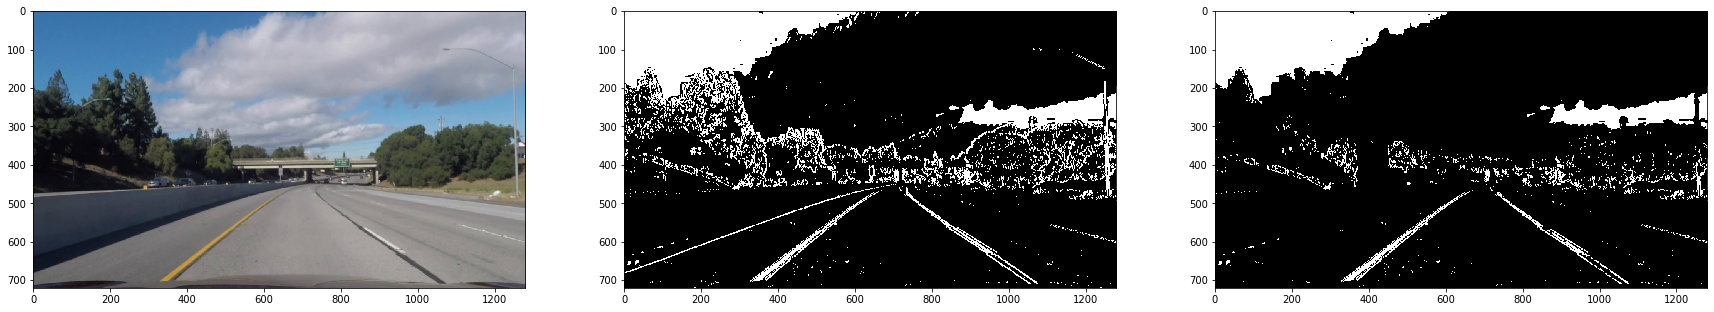

<Figure size 2160x1080 with 0 Axes>

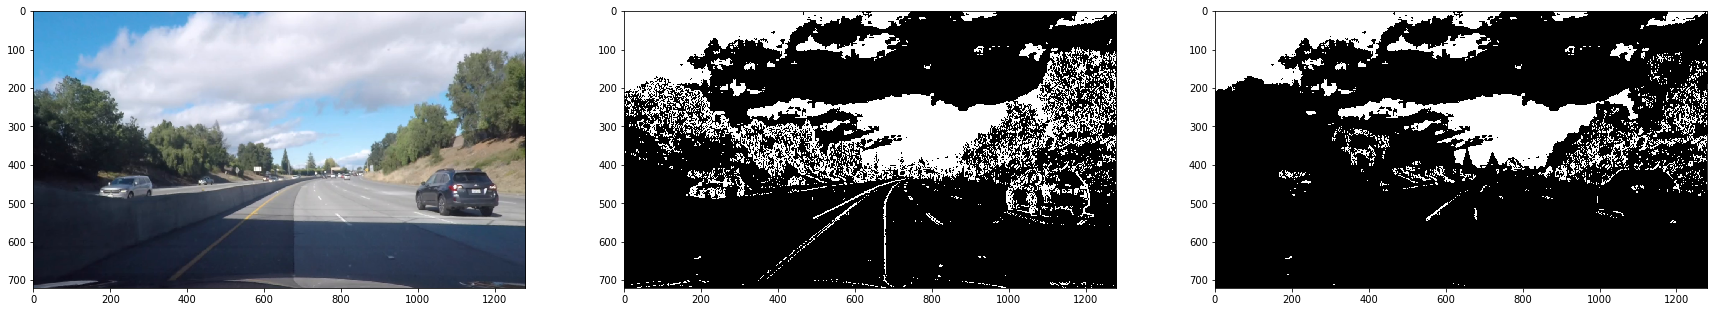

In [201]:
video = VideoFileClip('test_videos/challenge_video.mp4')

for i in range(2):
    img = video.get_frame(i*5)
    img_rect = undistort_image(img, m)
        
    ret, ret2 = pipeline(img_rect, s_thresh=(110, 255), sx_thresh=(10, 255))
    plt_imlist([img_rect, ret, ret2])